# EDA on Protest dataset

In this notebook, we explore the integrated dataset, to uncover the stories contained within this dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS 

In [2]:
df = pd.read_csv('../Data/integrated_protest.csv')

# create copy of dataset
df_violence = df.copy()

# function to binarize protest status
def yes_violence(row):
    if row == 'Peaceful protest':
        return 0
    else:
        return 1
    
# create binarized violence column based on sub_event_type
df_violence['violence'] = df_violence['sub_event_type'].apply(yes_violence)

In [3]:
df_violence['assoc_actor_1'] = df_violence['assoc_actor_1'].fillna('none')

In [4]:
# explore some features
features_explore = ['date','month','year','city','state','event_type','sub_event_type','actor1','assoc_actor_1','notes','attendees','totalpop','latitude','longitude','violence']
df_explore = df_violence[features_explore]
df_explore.shape

(27629, 15)

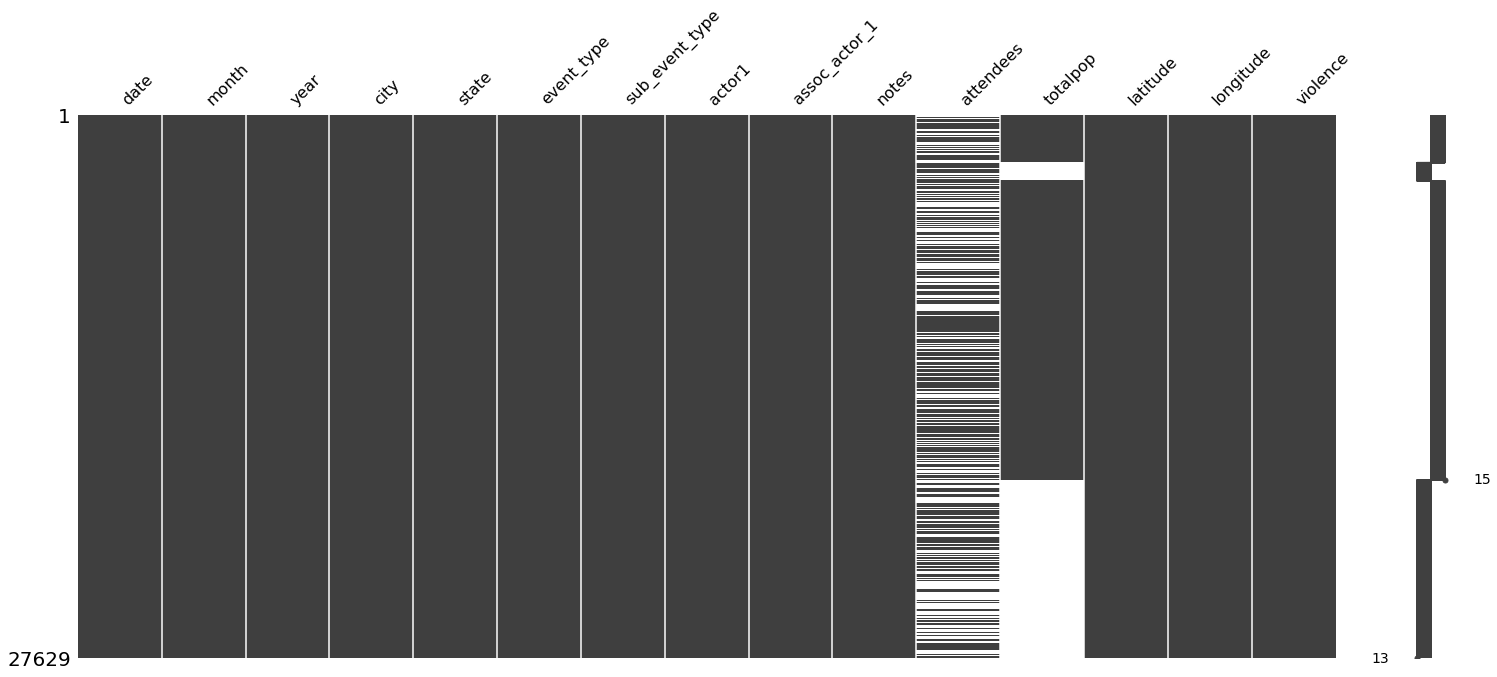

In [5]:
msno.matrix(df_explore.sort_values(by=['violence','totalpop'],ascending=False))
plt.show()

Questions:
1. When were the protests?
2. What was the highest 100 attendance numbers at protests?
3. Where were the protests for the highest 100 attendance numbers?
4. For 5 of these top 100 locations, what was the % of violent vs non-violent protests overall?
5. For these 5 locations, how persistent were protests (over how many consecutive weeks)?
6. Explore violence

## 1. Protest Distribution Over Time

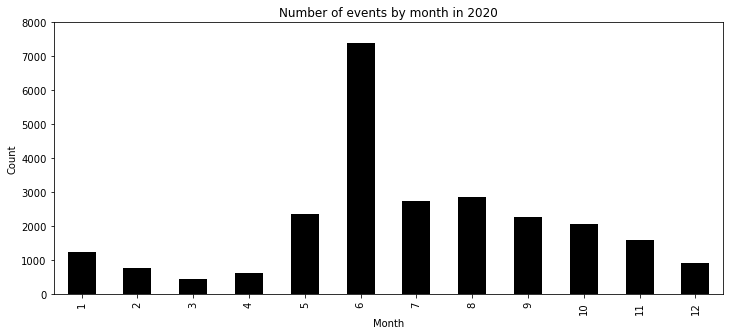

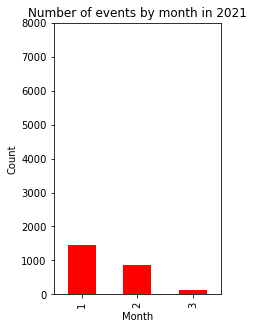

In [6]:
# what were protest counts like, over the months

plt.figure(figsize=(12,5))
df[df['year']!=2021].groupby(by='month')['date'].count().plot(kind="bar",color='black')
plt.title('Number of events by month in 2020')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 8000])
plt.show()

plt.figure(figsize=(3,5))
df[df['year']==2021].groupby(by='month')['date'].count().plot(kind="bar",color='red')
plt.title('Number of events by month in 2021')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 8000])
plt.show()

* March 2020: activity reduction when Covid shutdowns started
* June 2020: protests related to George Floyd
* Jan 2021: protest levels similar to Jan 2020. But this is also when the Jan 6th US Capitol protests occured

## 2. Attendees

In [7]:
# violent_100 = df_explore[(df_explore['violence']==1)].sort_values(by='attendees',ascending=False).head(100)

df_explore.describe()

,month,year,attendees,totalpop,latitude,longitude,violence
count,27629.000000,27629.000000,16257.000000,1.763500e+04,27629.000000,27629.000000,27629.000000
mean,6.421803,2020.087698,294.792951,4.380811e+05,38.514066,-93.412364,0.121901
std,2.936125,0.282860,2105.315090,7.131159e+05,5.199420,18.167429,0.327177
min,1.000000,2020.000000,0.000000,3.005500e+04,19.640200,-166.534100,0.000000
25%,5.000000,2020.000000,24.000000,6.880100e+04,35.045600,-111.831400,0.000000
50%,6.000000,2020.000000,100.000000,1.718640e+05,39.183400,-87.650100,0.000000
75%,8.000000,2020.000000,200.000000,5.488040e+05,41.874200,-78.878400,0.000000
max,12.000000,2021.000000,200000.000000,3.793097e+06,71.290600,-67.461400,1.000000


From the statistics, most protests were small (few hundred attendees). Probably in small towns across the US.

In [8]:
df_explore[df_explore['attendees']==200000]

,date,month,year,city,state,event_type,sub_event_type,actor1,assoc_actor_1,notes,attendees,totalpop,latitude,longitude,violence
8477,2020-06-06,6,2020,washington_dc,dc,Protests,Protest with intervention,Protesters (United States),BLM: Black Lives Matter,"On 6 June 2020, between 100000 to 200000 peopl...",200000.0,NaN,38.9171,-77.0003,1


Largest protest was in Washington DC. Though this location is missing population data <- this is a data issue what we don't fix in this project but will have to be handled for more accurate modeling.

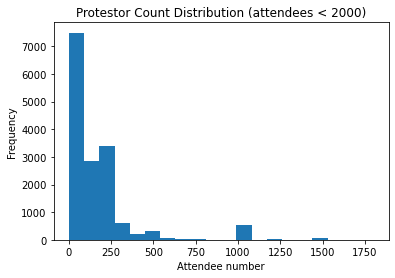

In [9]:
plt.hist(df_explore[df_explore['attendees']<2000]['attendees'], bins=20)
plt.title('Protestor Count Distribution (attendees < 2000)')
plt.xlabel('Attendee number')
plt.ylabel('Frequency')
plt.show()

#### How does atendee count distribution differ between peaceful and non-peaceful protests?

In [10]:
peaceful = df_explore[df_explore['violence']==0]
violent = df_explore[df_explore['violence']==1]

peaceful.shape, violent.shape

((24261, 15), (3368, 15))

In [11]:
peaceful.describe()[['attendees']]

,attendees
count,14386.000000
mean,253.787849
std,1267.315632
min,0.000000
25%,24.000000
50%,100.000000
75%,200.000000
max,80000.000000


In [12]:
violent.describe()[['attendees']]

,attendees
count,1871.000000
mean,610.078568
std,5105.231846
min,1.000000
25%,40.000000
50%,150.000000
75%,300.000000
max,200000.000000


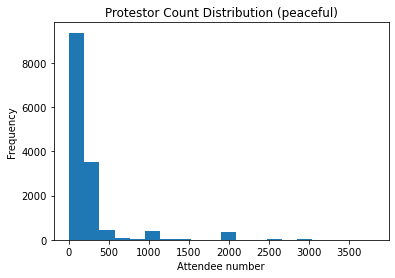

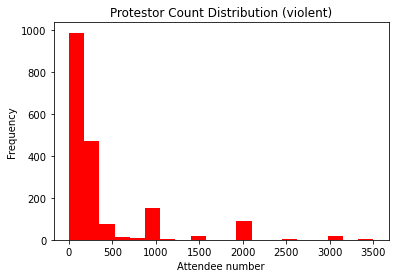

In [13]:
# attendee histogram: peaceful protests
plt.hist(peaceful[peaceful['attendees']<4000]['attendees'], bins=20)
plt.title('Protestor Count Distribution (peaceful)')
plt.xlabel('Attendee number')
plt.ylabel('Frequency')
plt.show()

# attendee histogram: violent protests
plt.hist(violent[violent['attendees']<4000]['attendees'], bins=20, color='red')
plt.title('Protestor Count Distribution (violent)')
plt.xlabel('Attendee number')
plt.ylabel('Frequency')
plt.show()

Still pretty similar - most protests are in the hundreds.

## 3. Location

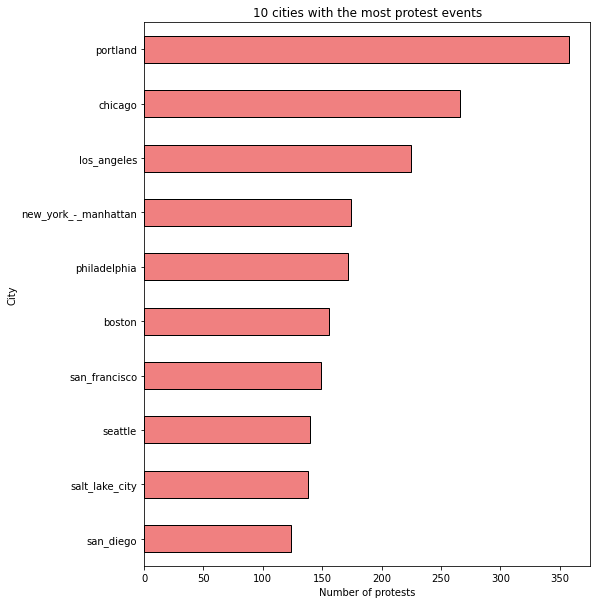

In [14]:
df_loc = df_explore.groupby(['city'])['attendees'].count()

plt.figure(figsize=(8,10))
df_loc.sort_values(ascending=True)[-10:].plot(kind='barh',color='lightcoral',edgecolor='black')
plt.xlabel('Number of protests')
plt.ylabel('City')
plt.title('10 cities with the most protest events')
plt.show()

Portland had the most number of protests.

## 4. Violent vs non-violent for 5 locations of large protests

In [15]:
city_list = ['portland','chicago','los_angeles','new_york_-_manhattan','philadelphia']

# Google: select row if column is in list
# https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values

df_5cities = df_explore[df_explore['city'].isin(city_list)]
df_5cities.shape

(1943, 15)

In [16]:
pct5 = df_5cities['violence'].sum()/df_5cities.shape[0]*100
pctorig = df_explore['violence'].sum()/df_explore.shape[0]*100
print(f'Percentage of protests with violence for 5 cities: {round(pct5,2)}%')
print(f'Percentage of protests with violence for whole dataset: {round(pctorig,2)}%')

Percentage of protests with violence for 5 cities: 23.67%
Percentage of protests with violence for whole dataset: 12.19%


Occurrence of violence at protests in these 5 cities is ~2X the national occurrence.

## 5. Longevity/persistence of protests

In [17]:
df_5cities.groupby(by='city').sum()[['attendees','violence']]

,attendees,violence
city,,
chicago,124207.0,43
los_angeles,165139.0,81
new_york_-_manhattan,74296.0,49
philadelphia,118755.0,44
portland,180131.0,243


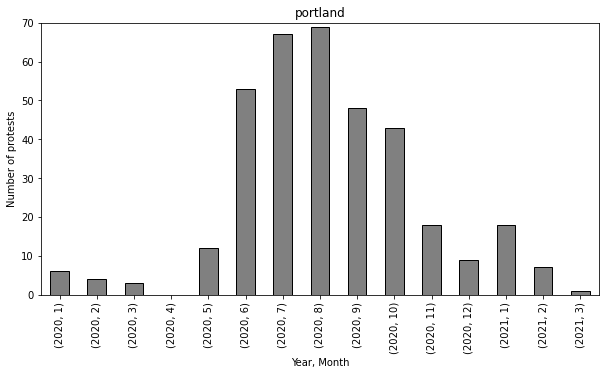

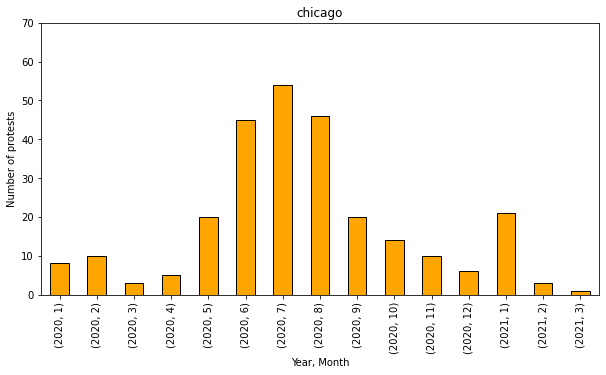

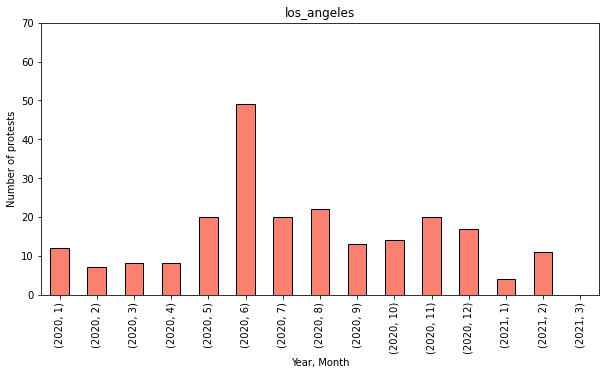

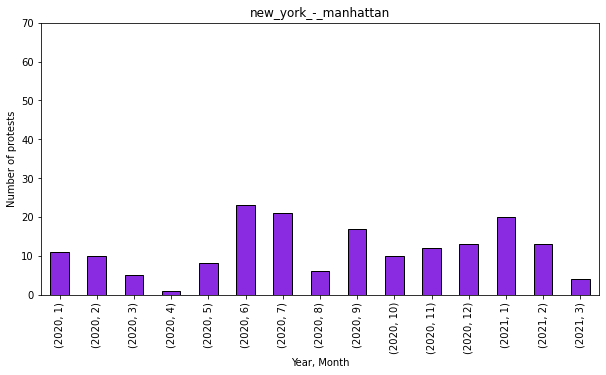

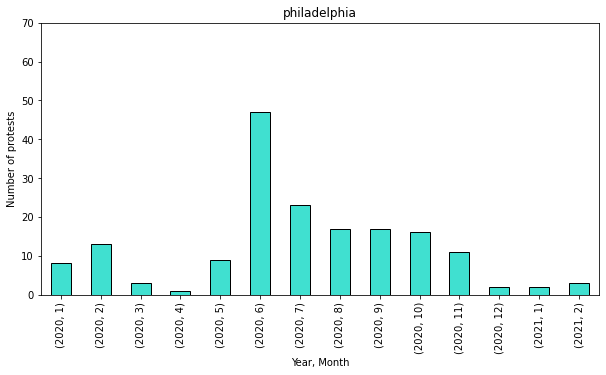

In [18]:
# Google: python pd plot count by date
# https://medium.com/@danalindquist/https-medium-com-danalindquist-bar-chart-of-weekly-data-count-using-pandas-5c95a536a08e

colors = ['gray','orange','salmon','blueviolet','turquoise']

for i in range(len(city_list)):
    city = city_list[i]
    df_city = df_5cities[df_5cities['city']==city]
    month_groups = df_city.groupby([df_city['year'],df_city['month']])['attendees'].count()
    month_groups.plot(kind='bar',figsize=(10,5),legend=None,color = colors[i],edgecolor='black')
    plt.title(city)
    plt.xlabel('Year, Month')
    plt.ylabel('Number of protests')
    plt.ylim([0,70])
    plt.show()

By far the most protests occurred in Portland.

## Try mapping this out

In [19]:
# make new df with city, state, latitude, longitude, number of protests

cities = df_violence.drop_duplicates(subset=['city']).reset_index(drop=True)
cities = cities[['city','state','latitude','longitude']]

event_count = df_violence.groupby(by='city')[['id']].count().reset_index(drop=True)
event_count.shape

cities_count = pd.concat([cities,event_count],axis=1)
sub_cities_count = cities_count[(cities_count['state']!='ak') & (cities_count['state']!='hi')]
# cities_count.drop(cities_count[cities_count['state']=='ak'], inplace=True)
# df.drop(df[df.score < 50].index, inplace=True)
sub_cities_count.shape

(3598, 5)

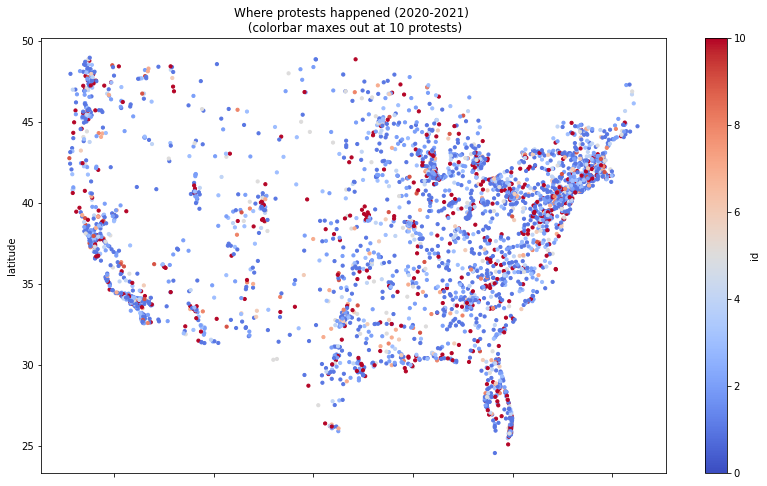

In [20]:
sub_cities_count.plot(kind="scatter", x="longitude", y="latitude", c="id",
         cmap="coolwarm", figsize=(14, 8), s=10,
                     vmin=0, vmax=10);
plt.title('Where protests happened (2020-2021) \n (colorbar maxes out at 10 protests)');

## 6. Explore Violence

### Where does violence information show up in our dataset?

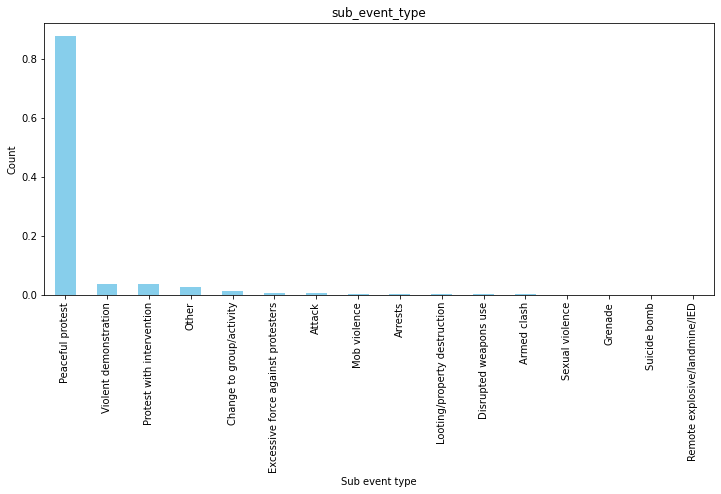

In [21]:
# sub_event_type
plt.figure(figsize=(12,5))
df['sub_event_type'].value_counts(normalize=True, dropna=False).plot(kind='bar',color='skyblue')
plt.title('sub_event_type')
plt.xlabel('Sub event type')
plt.ylabel('Count')
plt.show()

In [22]:
df['sub_event_type'].value_counts(normalize=True, dropna=False), df['event_type'].value_counts(normalize=True, dropna=False)

(Peaceful protest                      0.878099
 Violent demonstration                 0.036194
 Protest with intervention             0.034963
 Other                                 0.024648
 Change to group/activity              0.013030
 Excessive force against protesters    0.004597
 Attack                                0.003800
 Mob violence                          0.001737
 Arrests                               0.001158
 Looting/property destruction          0.000796
 Disrupted weapons use                 0.000434
 Armed clash                           0.000362
 Sexual violence                       0.000072
 Grenade                               0.000036
 Suicide bomb                          0.000036
 Remote explosive/landmine/IED         0.000036
 Name: sub_event_type, dtype: float64,
 Protests                      0.917659
 Strategic developments        0.040067
 Riots                         0.037931
 Violence against civilians    0.003873
 Battles                       0.

88% of protests are peaceful. But these columns don't say anything about police intervention.

### Is it possible to classify columns based on police-related violence
#### Instead of both protestor and police-related violence?

In [23]:
# police in notes?
police_notes = df[df['notes'].str.contains('police')]

# percentage of dataset with mention of police
police_notes.shape[0]/df.shape[0]*100

40.73980238155561

In [24]:
# let's look at a smaller dataset
# look at notes contents from protests in June (George Floyed summer of protest)
police_june = police_notes[(police_notes['month']==6)].copy()
police_june.shape

(6038, 68)

In [25]:
police_june[['attendees']].describe().T

,count,mean,std,min,25%,50%,75%,max
attendees,4173.0,544.69758,3815.777688,1.0,100.0,200.0,300.0,200000.0


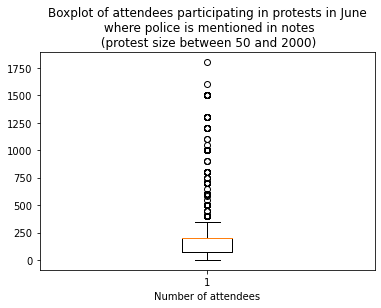

In [26]:
plt.boxplot(police_june[police_june['attendees']<2000]['attendees'])
plt.title('Boxplot of attendees participating in protests in June\n where police is mentioned in notes\n (protest size between 50 and 2000)')
plt.xlabel('Number of attendees')
plt.show()

Lots of small protests (small towns across America?).

In [27]:
# Look at some examples from larger protests
police_june[police_june['attendees']>500]['notes'].head(5)

5459    On 1 June 2020, 500 - 600 people marched from ...
5480    On 1 June 2020, hundreds of people demonstrate...
5491    On 1 June 2020, thousands protested and a grou...
5495    On 1 June 2020, an estimated 1000 people demon...
5497    On 1 June 2020, thousands of Black Lives Matte...
Name: notes, dtype: object

'police' is mentioned either because George Floyd was killed by police, or police were violent with protestors.

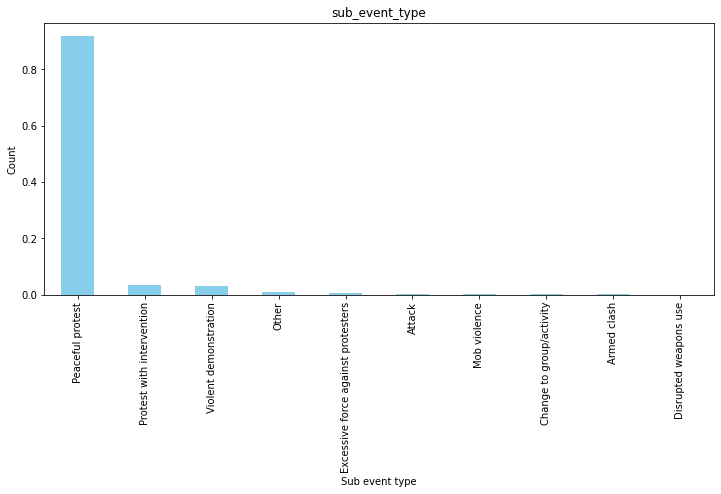

In [28]:
# what portion of these protests were classified as peaceful vs not?
# by the dataset collectors?

# sub_event_type
plt.figure(figsize=(12,5))
police_june['sub_event_type'].value_counts(normalize=True, dropna=False).plot(kind='bar',color='skyblue')
plt.title('sub_event_type')
plt.xlabel('Sub event type')
plt.ylabel('Count')
plt.show()

Percentage-wise, it's still similar to the yearly distribution (~90% peaceful protest). But of the 5 we pulled up above, 4 (80%) had mention of police violence. So just because the protest is organized as peaceful (and is logged as peaceful), does not mean there was not ensuing police violence. Let's see if we can somehow extract this information and create new columns for this. Method:
1. count-vectorize the notes, checking to see whether we need to use the English stopwords
2. look at (most common?) words, bigrams, trigrams
3. decide what collection of words would indicate: protestor violence vs police violence
4. count how many occurrences of these words exist, and log in new column
5. compare these occurrences

## 1. Count-vectorize

In [29]:
# df of just the notes
notes = police_june['notes'] 

# count-vectorize
cvec = CountVectorizer(stop_words = 'english')
# cvec = CountVectorizer()

# Fit the count vectorizer on the notes
cvec.fit(notes)

# transform the corpus
notes_cv = cvec.transform(notes)

# store the transformed data
notes_cv_df = pd.DataFrame(notes_cv.todense(), columns=cvec.get_feature_names())
notes_cv_df.head()

,000,10,100,1000,10000,100000,100people,101,105,11,...,yucaipa,zachary,zampa,zelasko,zenos,zephyrhills,zionsville,zip,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
notes_cv_df.shape
# 6315 no stopwords, 6107 with stopwords.

(6038, 6107)

## 2. Look at most common words and bigrams

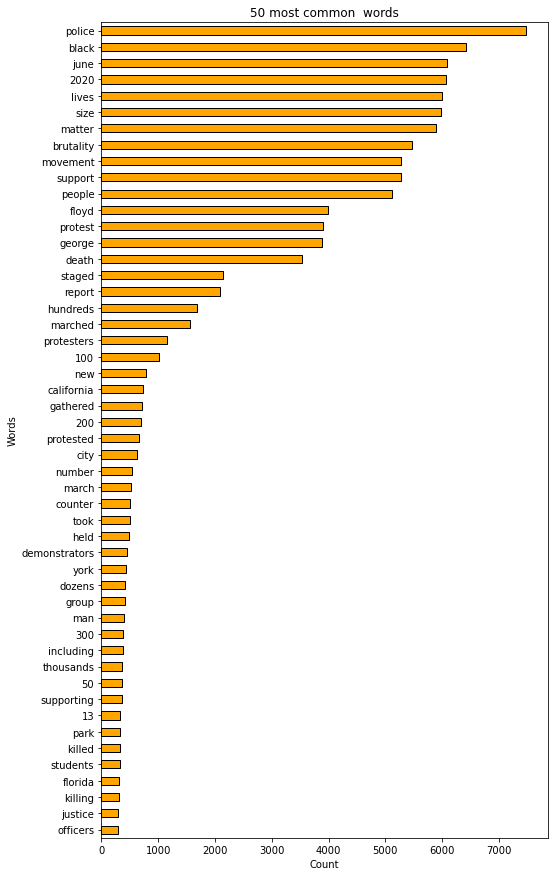

In [31]:
# show 50 most common words (with stopwords)
plt.figure(figsize=(8,15))
notes_cv_df.sum().sort_values(ascending=True).tail(50).plot(kind='barh', color='orange', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title("50 most common  words")
plt.show()

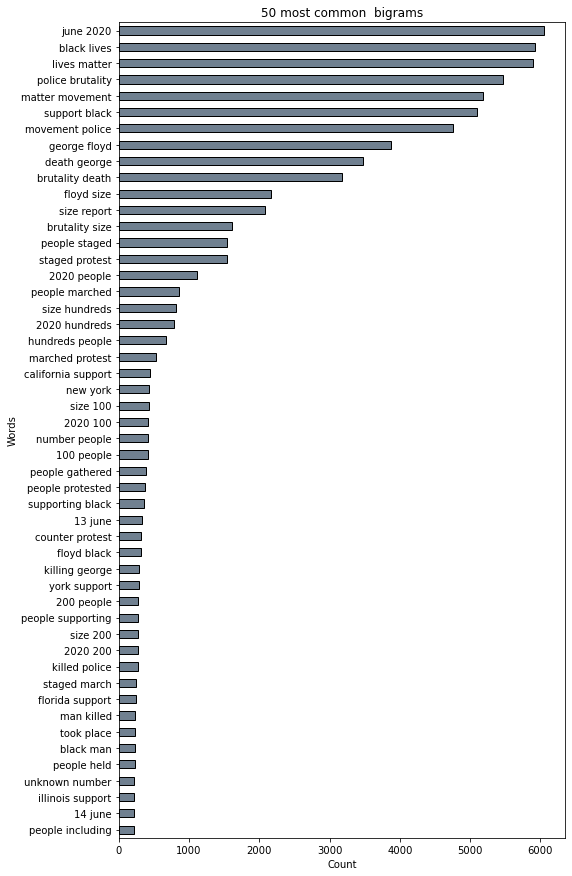

In [32]:
# This is not a great way to pick out police violence-related words. Numbers show up here too
# What about bigrams?

cvec_bi = CountVectorizer(stop_words = 'english', ngram_range=(2,2))
cvec_bi.fit(notes)
notes_cv_bi = cvec_bi.transform(notes)
notes_cv_bi_df = pd.DataFrame(notes_cv_bi.todense(), columns=cvec_bi.get_feature_names())

# show 50 most common bigrams (with stopwords)
plt.figure(figsize=(8,15))
notes_cv_bi_df.sum().sort_values(ascending=True).tail(50).plot(kind='barh', color='slategray', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title("50 most common  bigrams")
plt.show()

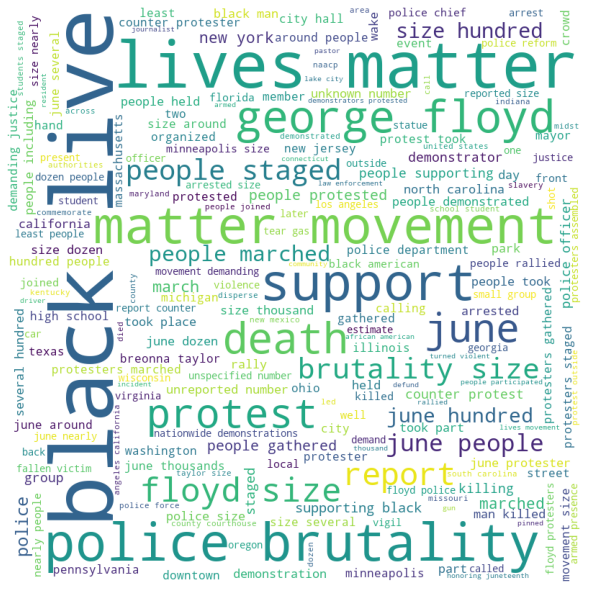

In [33]:
# This is still not a great way to pick out police violence-related words
# What about word cloud?

# Google: create word cloud python
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# mask = np.array(Image.open('../images/usa2.jpg'))
# wc = WordCloud(stopwords=STOPWORDS, font_path=font_path,
#                mask=mask, background_color="white",
#                max_words=2000, max_font_size=256,
#                random_state=42, width=mask.shape[1],
#                height=mask.shape[0])
# wc.generate(article.text)
# plt.imshow(wc, interpolation="bilinear")
# plt.axis('off')
# plt.show()

comment_words = '' 
stopwords = set(STOPWORDS)
  
# iterate through the df
for val in police_june['notes']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

This does not seem like a good way to go about this. For one, these protests are against police brutality and the killing of George Floyd to begin with, so all notes have mention of police, and terms related to police brutality e.g. death and police brutality. What if we look for an external source of tools available to police for crowd control?

Wikipedia [riot control[(https://en.wikipedia.org/wiki/Riot_control#:~:text=Since%20the%201980s%2C%20riot%20control,or%20mounted%20police%20on%20horses.): baton, whip, tear gas, pepper spray, rubber bullet, taser, water cannon

## 3. Decide what collection of words would indicate police violence during the protest

In [34]:
# s = "On 1 June 2020, hundreds of people demonstrated in Philadelphia (Pennsylvania) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. One police officer was fired and faces assault charges after videos showed him pepper-spraying demonstrators directly in their faces. Police reponse to the demonstration was excessive by their own admission; 'City leaders have since apologized to the public after tear gas, bean bags and pepper spray were used against protesters who were trapped on the highway.' [size=at least 200]"
s = "On 1 June 2020, 500 - 600 people marched from the public library to the police station in Bangor (Maine) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=500-600]"
words = ['baton','whip','tear','gas','pepper','bullet','taser','cannon','arrest','clash','weapon']
# if words in s:
#     print('Yes')

def words_in_string(s):
    if set(words).intersection(s.split()):
        return 1
    else:
        return 0

# if words_in_string(words, s):
#     print('One or more words found!')


In [35]:
police_june['word_violence'] = police_june['notes'].apply(words_in_string)

In [36]:
# calculate percentage of protests met with police violence
police_june['word_violence'].value_counts()[1]/police_june.shape[0]*100

2.4345809870818154

In [37]:
# display original dataset's designation of non-peaceful protest count
police_june['sub_event_type'].value_counts()

Peaceful protest                      5554
Protest with intervention              204
Violent demonstration                  183
Other                                   58
Excessive force against protesters      27
Attack                                   4
Mob violence                             3
Change to group/activity                 2
Armed clash                              2
Disrupted weapons use                    1
Name: sub_event_type, dtype: int64

Our method defined 2.4% of protests as resulting in police violence, which is lower than that of the original dataset (even just protest with intervention + excessive force against protesters).

In [38]:
# Check to see the events I mischaracterized (I said police violence but actually not)
police_june[(police_june['sub_event_type']=='Peaceful protest') & (police_june['word_violence']==1)][['notes','sub_event_type','word_violence']].head(5)

,notes,sub_event_type,word_violence
6548,"On 3 June 2020, several hundred people staged ...",Peaceful protest,1
6549,"On 3 June 2020, several hundred people staged ...",Peaceful protest,1
8747,"On 6 June 2020, hundreds of people participate...",Peaceful protest,1
9185,"On 7 June 2020, about 11,000 protesters, organ...",Peaceful protest,1
9615,"On 9 June 2020, hundreds of people staged a ma...",Peaceful protest,1


In [39]:
# Check to see the events I mischaracterized (I said no police violence but actually there was)
police_june[(police_june['sub_event_type']!='Peaceful protest') & (police_june['word_violence']==0)][['notes','sub_event_type','attendees','word_violence']].head(10)

,notes,sub_event_type,attendees,word_violence
5458,"On 1 June 2020, an unreported number of people...",Violent demonstration,200.0,0
5460,"Non-violent activity: On 1 June 2020, two men,...",Other,100.0,0
5463,"On 1 June 2020, people staged a protest in Can...",Protest with intervention,300.0,0
5476,"On 1 June 2020, several groups of people vanda...",Violent demonstration,5.0,0
5483,"On 1 June 2020, around 50 people held a demons...",Protest with intervention,50.0,0
5491,"On 1 June 2020, thousands protested and a grou...",Violent demonstration,15000.0,0
5497,"On 1 June 2020, thousands of Black Lives Matte...",Protest with intervention,2000.0,0
5503,"Non-violent activity: On 1 June 2020, a couple...",Other,1000.0,0
5504,"Non-violent activity: On 1 June 2020, a couple...",Other,5.0,0
5506,"On 1 June 2020, hundreds of people gathered in...",Excessive force against protesters,200.0,0


Let's just drop the word_violence column and stick to the dataset's original characterization.